# Dimension reduction analyses of the ARGO data

The Argo data consist of paired multivariate observations for temperature and salinity, measured at the same location at the same time.  Each observation is a 100-dimensional vector of either temperature or salinity as a function of pressure.  Here we use dimension reduction methods including Principal Components Analysis (PCA) and Canonical Correlation Analysis (CCA) to better understand these profiles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from statsmodels.regression.dimred import SIR
from read import *

Construct a variable called 'days' that is the number of days since the first date in the dataset.

In [2]:
date = pd.to_datetime(date)
ddate = date - date.min()
day = [x.days for x in ddate]

Get the circular mean of all longitude values.  This isn't related to dimension reduction but is useful to know for orientation.

In [3]:
lon_sin = np.sin(2*np.pi*lon/360)
lon_cos = np.cos(2*np.pi*lon/360)
cmean_lon = np.arctan2(lon_sin.mean(), lon_cos.mean()) * 360 / (2*np.pi)
cmean_lon

-150.68855482920793

Translate the longitude values so that the Pacific ocean doesn't wrap around the origin.

In [4]:
lonx = (lon + 60) % 360

Create a matrix of observed variables that describe the location and time at which each profile was obtained.

In [5]:
n = len(lat)
Y = np.zeros((n, 4))
Y[:, 0] = lat
Y[:, 1] = lon  # raw longitude
Y[:, 2] = lonx # translated longitude
Y[:, 3] = day

Plot the profile locations in the actual latitude/longitude coordinates.  Longitude 0 is the prime meridian (passes through England).

Text(0.5, 1.0, 'Float positions')

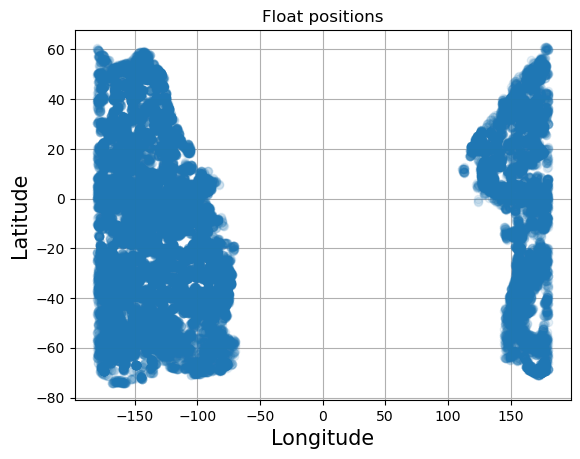

In [6]:
plt.clf()
plt.grid(True)
plt.plot(lon, lat, "o", rasterized=True, alpha=0.1)
plt.xlabel("Longitude", size=15)
plt.ylabel("Latitude", size=15)
plt.title("Float positions")

Plot the profile locations using translated longitudes.

Text(0.5, 1.0, 'Float positions')

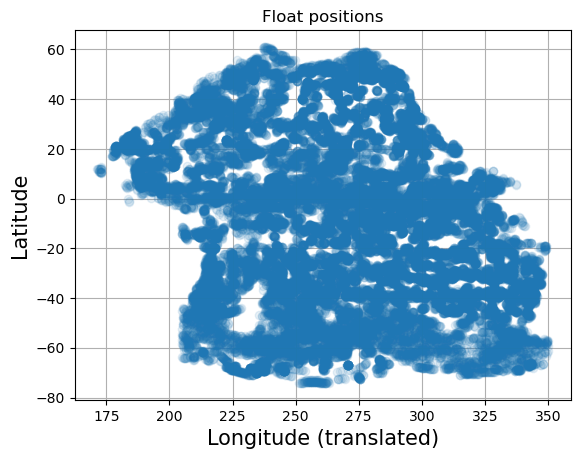

In [7]:
plt.clf()
plt.grid(True)
plt.plot(lonx, lat, "o", rasterized=True, alpha=0.1)
plt.xlabel("Longitude (translated)", size=15)
plt.ylabel("Latitude", size=15)
plt.title("Float positions")

In [8]:
def get_pcs(x):
    """
    Get the principal components of the data in x, treating the rows as the
    variables and the columns as the observations.
    """
    xc = x.copy()
    xm = x.mean(1)
    xc -= xm[:, None]
    cc = np.cov(xc)
    pcw, pcv = np.linalg.eigh(cc)

    # Reorder the PC's so that the dominant factors
    # are first.
    ii = np.argsort(pcw)[::-1]
    pcw = pcw[ii]
    pcv = pcv[:, ii]

    # For interpretability flip the PC's that are
    # mostly negative.
    for j in range(pcv.shape[1]):
        if (pcv[:, j] < 0).sum() > (pcv[:, j] >= 0).sum():
            pcv[:, j] *= -1

    # Get the PC scores
    scores = np.dot(xc.T, pcv[:, 0:5])

    return xm, pcw, pcv, scores

In [9]:
def pcplot(j, mean, pcv, scores, label):
    """
    Plot the j^th PC score against all features.
    """
    # Plot the PC loadings
    plt.clf()
    plt.grid(True)
    plt.plot(pressure, pcv[:, j])
    plt.gca().set_xlabel("Pressure", size=15)
    plt.gca().set_ylabel("%s PC %d loading" % (label.title(), j + 1), size=15)
    if pcv[:, j].min() > 0:
        plt.gca().set_ylim(ymin=0)
    plt.show()

    # Plot the mean +/- 1 SD of the loading pattern
    plt.clf()
    plt.title(label.title())
    plt.grid(True)
    s = scores[:, j].std()
    for f in [-1, 0, 1]:
        plt.plot(pressure, mean + f*s*pcv[:, j], color={-1: "blue", 0: "black", 1: "red"}[f])
    plt.gca().set_xlabel("Pressure", size=15)
    plt.gca().set_ylabel("Mean %s +/- PC %d loading" % (label, j + 1), size=15)
    plt.show()

    # Plot the conditional mean PC score against an observed variable,
    # showing the conditional mean plus/minus one mean absolute deviation.
    fn = ["Latitude", "Longitude", "Longitude", "Day"]
    for k in [0,1,3]:
        xx = np.linspace(Y[:, k].min(), Y[:, k].max(), 100)
        m = lowess(scores[:, j], Y[:, k], delta=0.01*np.ptp(Y[:, k]))
        resid = scores[:, j] - m[:, 1]
        r = lowess(np.abs(resid), Y[:, k], delta=0.01*np.ptp(Y[:, k]))
        yy = interp1d(m[:, 0], m[:, 1])(xx)
        yr = interp1d(r[:, 0], r[:, 1])(xx)
        f = 2
        ymx = (yy + f*yr).max()
        ymn = (yy - f*yr).min()
        plt.clf()
        plt.grid(True)
        plt.plot(xx, yy, "-", color="red")
        plt.plot(xx, yy-f*yr, "-", color="grey")
        plt.plot(xx, yy+f*yr, "-", color="grey")
        plt.gca().set_ylim([ymn, ymx])
        plt.gca().set_xlabel(fn[k], size=15)
        plt.gca().set_ylabel("%s PC %d score" % (label.title(), j + 1), size=15)
        plt.show()

In [10]:
tempmean, tempw, tempv, tempscores = get_pcs(temp)
psalmean, psalw, psalv, psalscores = get_pcs(psal)

Plot the mean profiles for temperature and salinity.

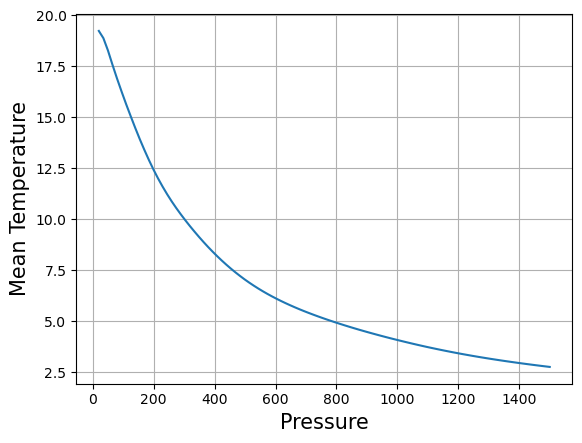

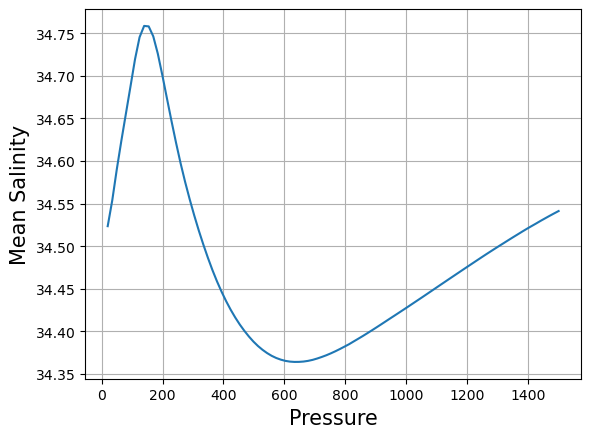

In [11]:
for ti,da in zip(["Temperature", "Salinity"], [tempmean, psalmean]):
    plt.clf()
    plt.grid(True)
    plt.plot(pressure, da)
    plt.gca().set_xlabel("Pressure", size=15)
    plt.gca().set_ylabel("Mean %s" % ti, size=15)
    plt.show()

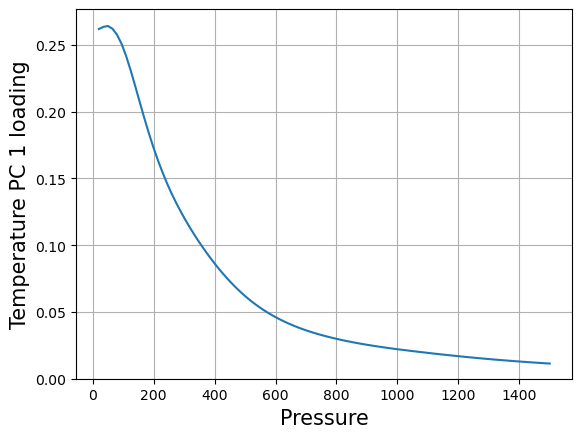

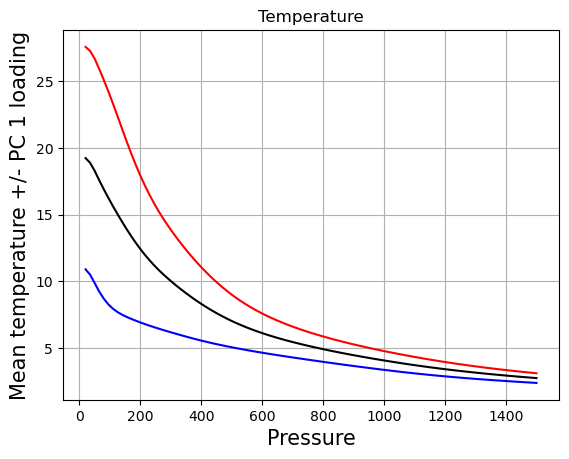

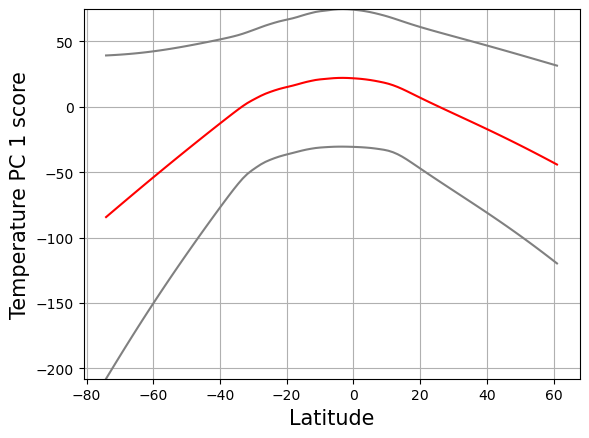

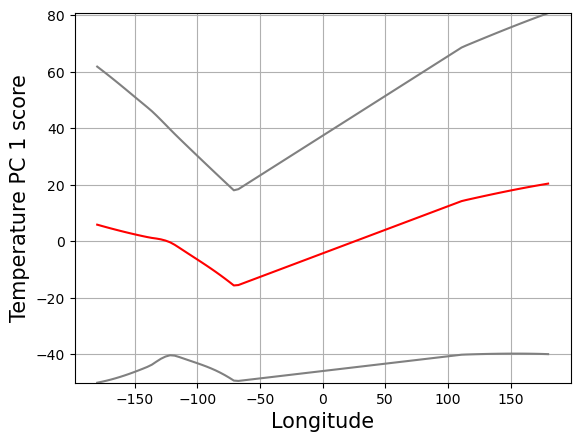

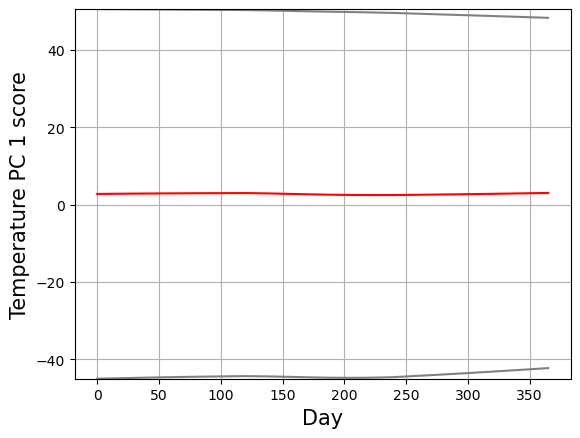

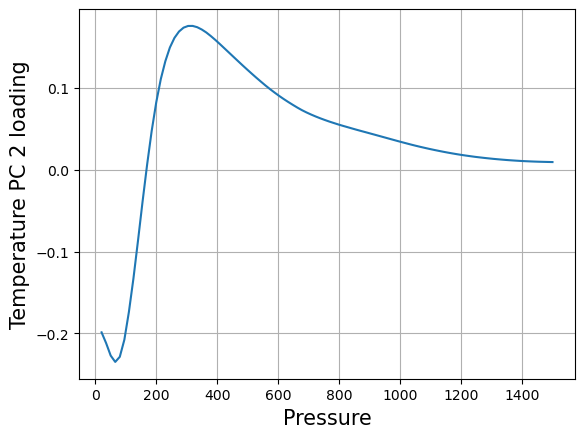

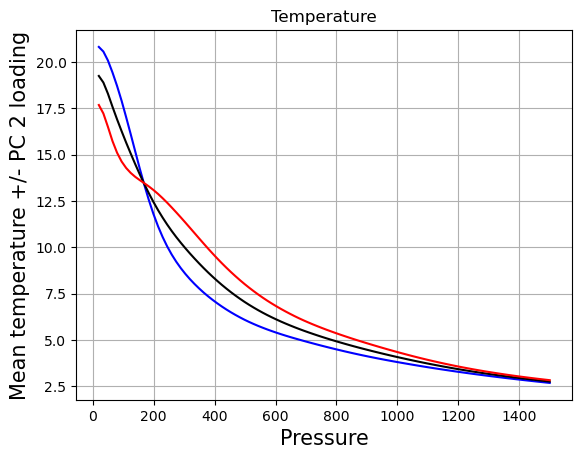

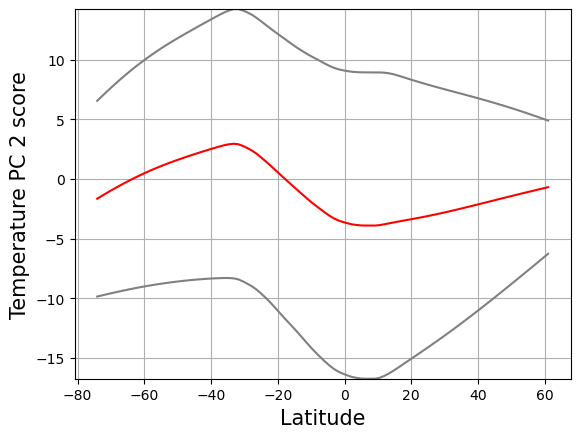

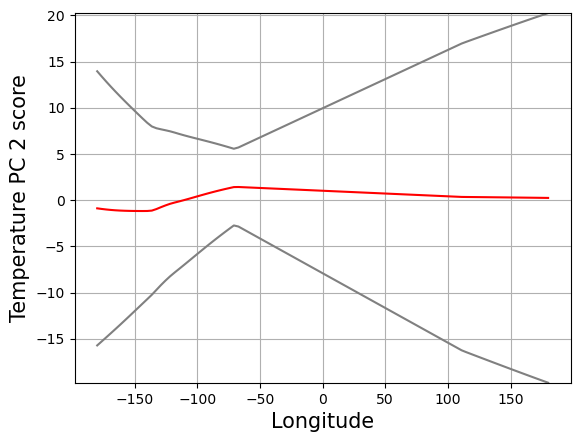

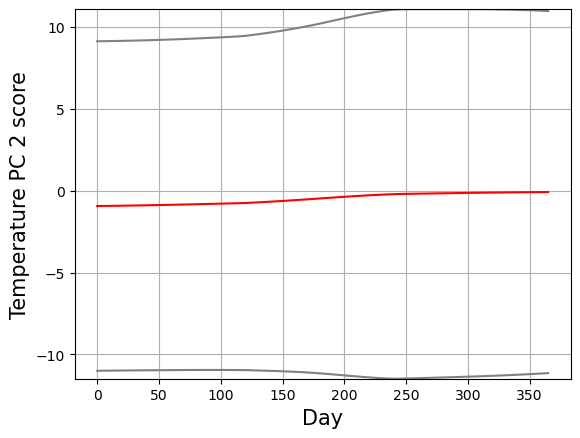

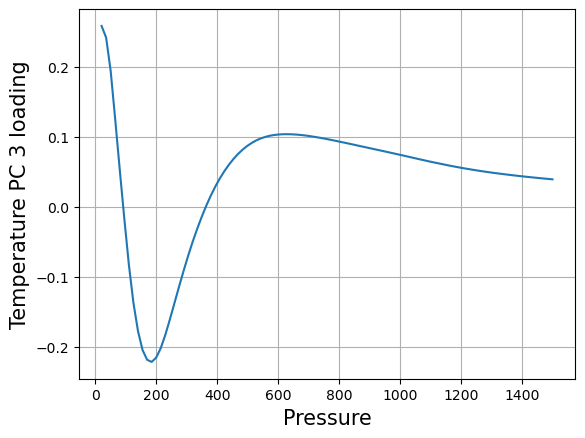

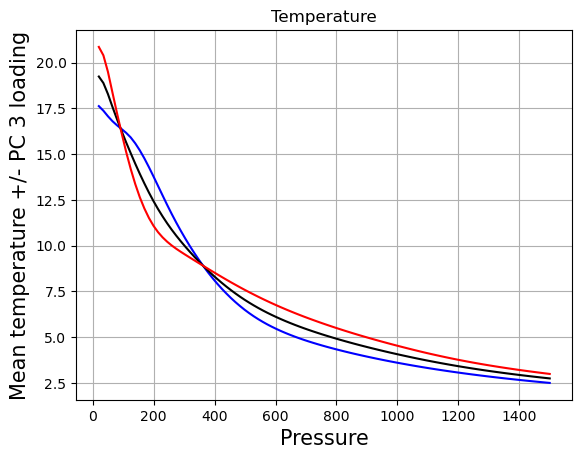

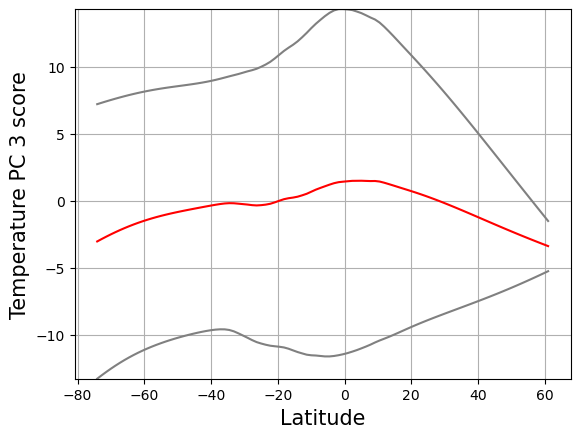

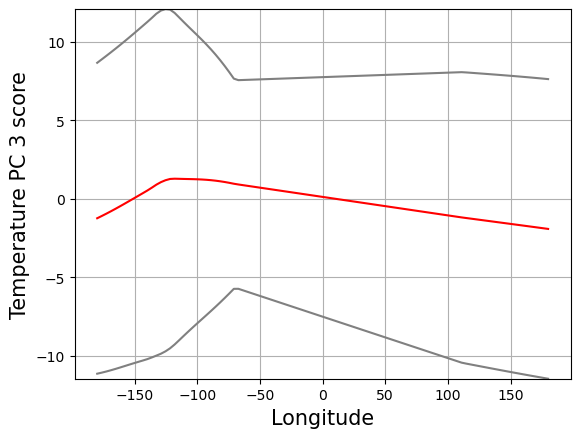

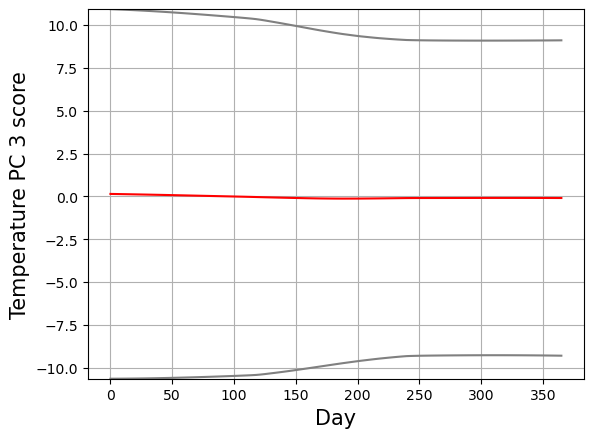

In [12]:
for j in [0, 1, 2]:
    pcplot(j, tempmean, tempv, tempscores, "temperature")

Another way to understand the meaning of the PCA is to identify the geographic locations where profiles score at the high end or the low end of scores for each PC.  These plots are constructed and shown below.

In [13]:
def plot_pc_map(j, tempscores, Y, title):
    plt.clf()
    plt.figure(figsize=(9, 7.25))
    ax = plt.axes([0.05, 0.05, 0.84, 0.88], projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    ax.set_extent([115, 290, -70, 60])

    jj = np.flatnonzero(tempscores[:, j] >= np.quantile(tempscores[:, j], 0.9))
    plt.scatter(Y[jj, 1], Y[jj, 0], s=8, label="Top 10%", color="red", transform=ccrs.Geodetic(), rasterized=True)
    jj = np.flatnonzero(tempscores[:, j] <= np.quantile(tempscores[:, j], 0.1))
    plt.scatter(Y[jj, 1], Y[jj, 0], s=8, label="Bottom 10%", color="blue", transform=ccrs.Geodetic(), rasterized=True)

    ha,lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)

    plt.title("%s (component %d)" % (title, j))
    plt.show()

<Figure size 640x480 with 0 Axes>

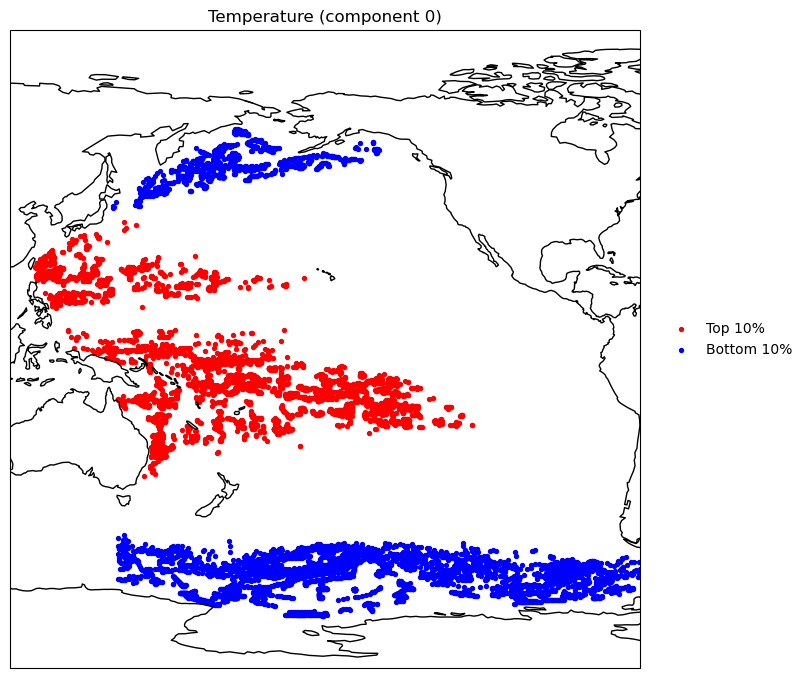

<Figure size 640x480 with 0 Axes>

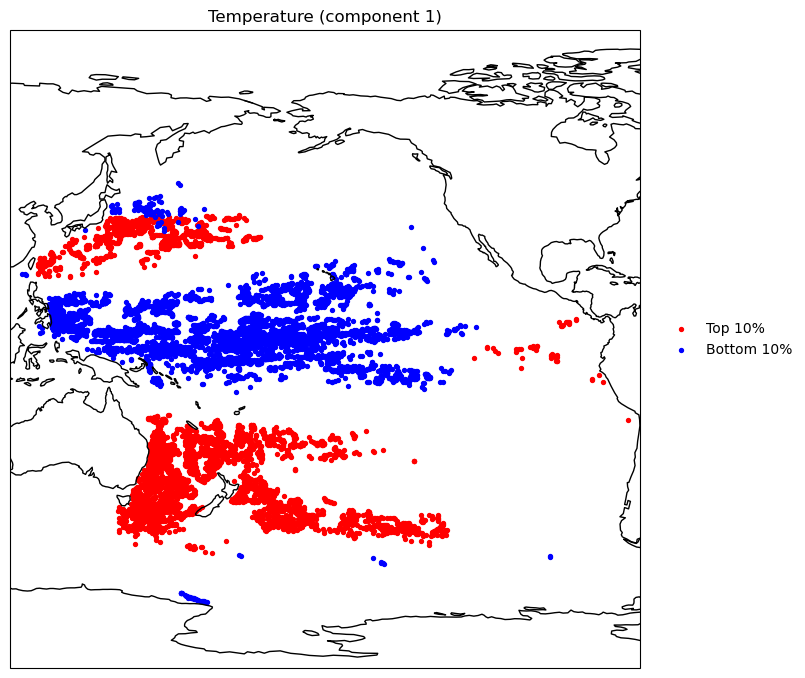

<Figure size 640x480 with 0 Axes>

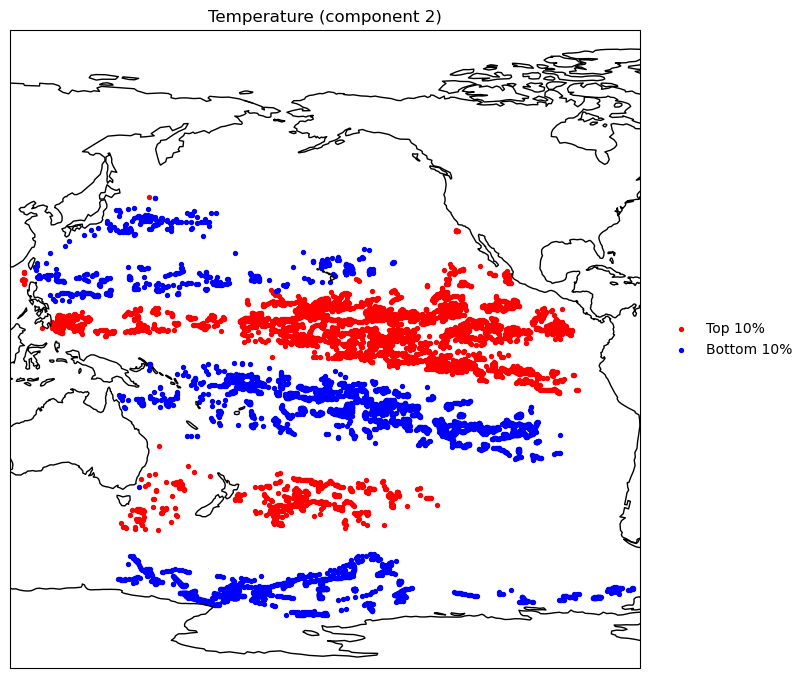

In [14]:
for j in range(3):
    plot_pc_map(j, tempscores, Y, "Temperature")

<Figure size 640x480 with 0 Axes>

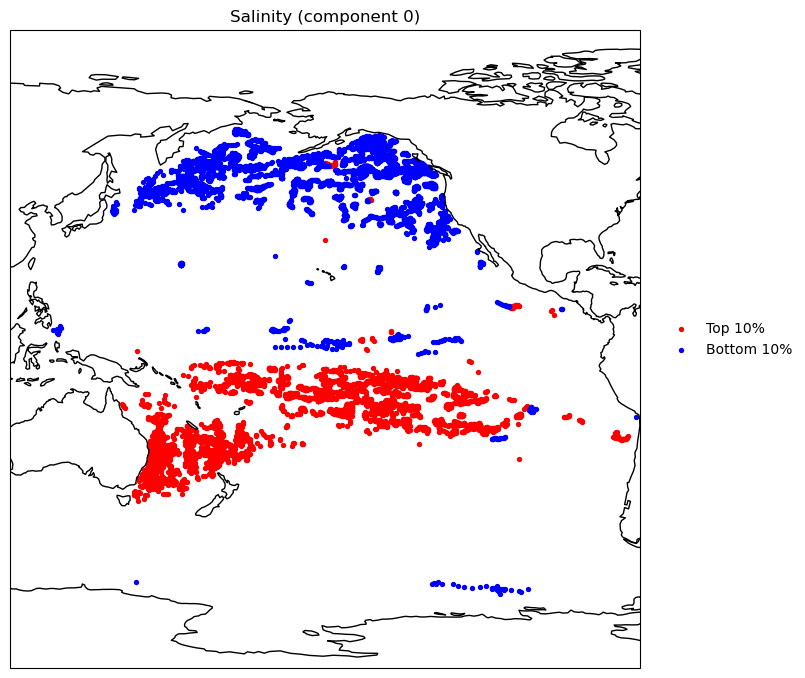

<Figure size 640x480 with 0 Axes>

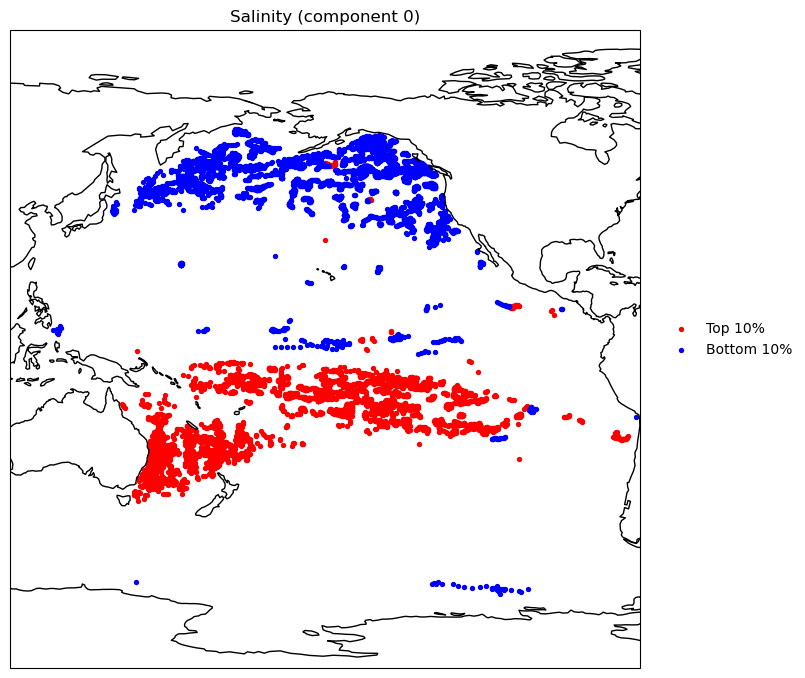

<Figure size 640x480 with 0 Axes>

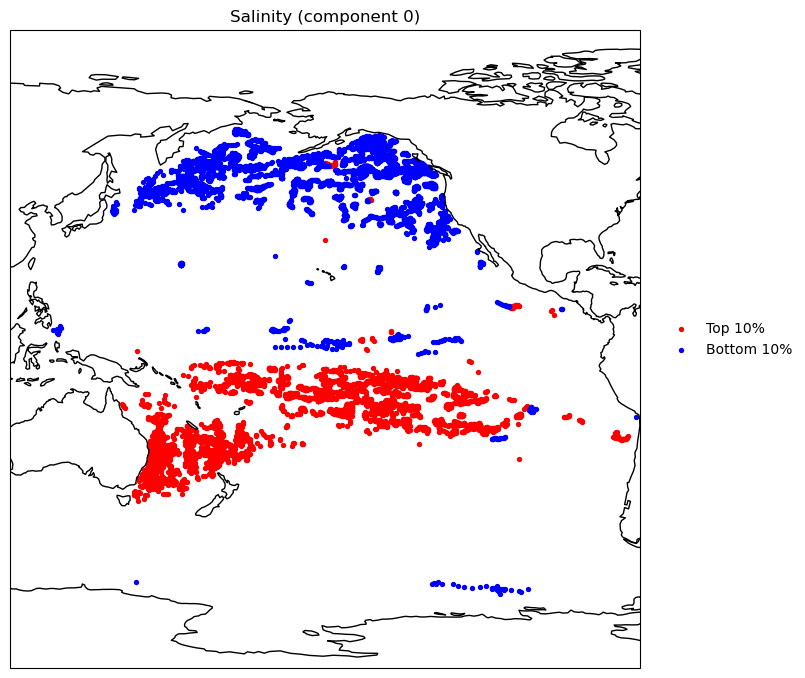

In [15]:
for j in range(3):
    plot_pc_map(0, psalscores, Y, "Salinity")

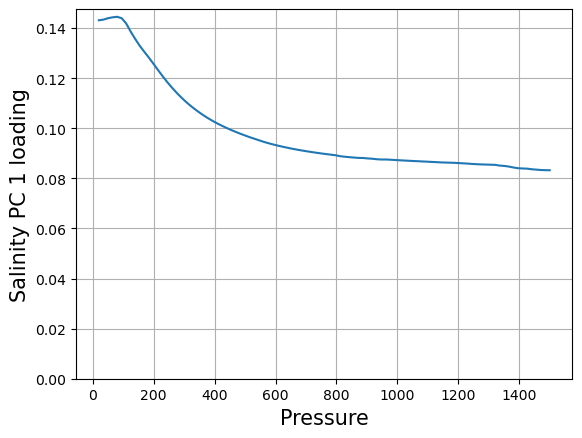

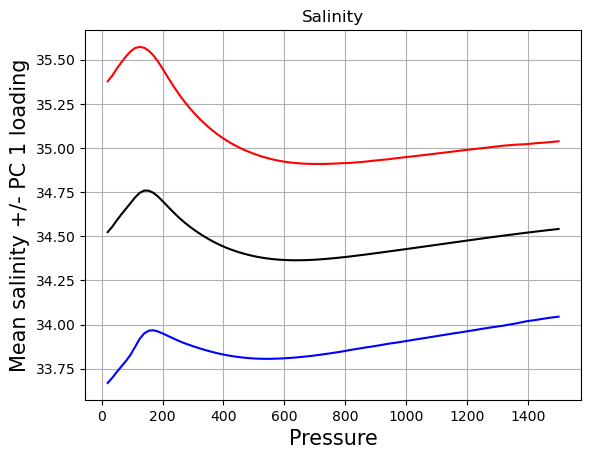

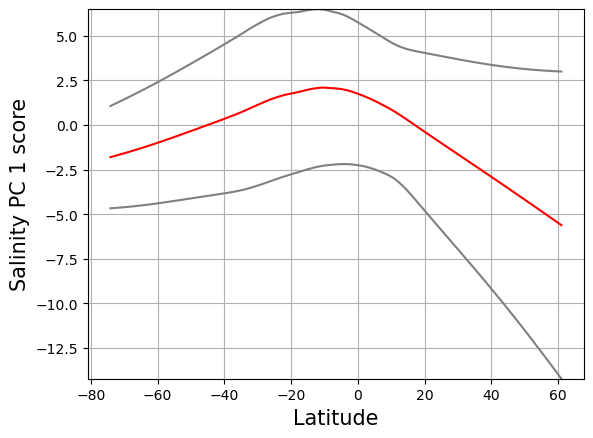

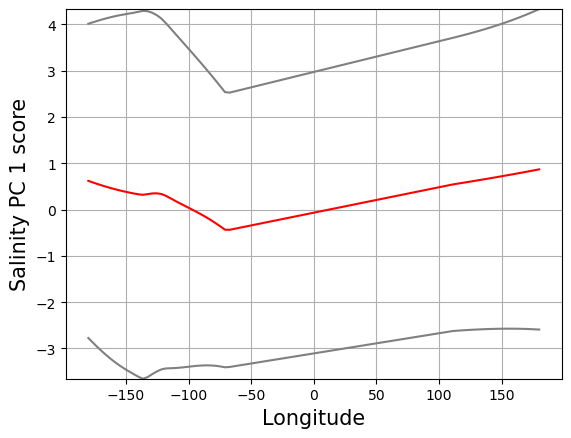

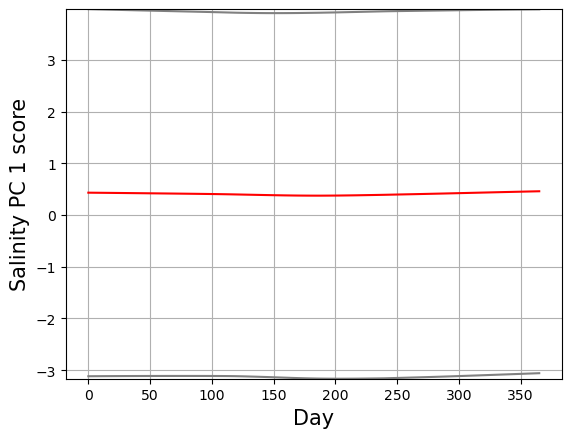

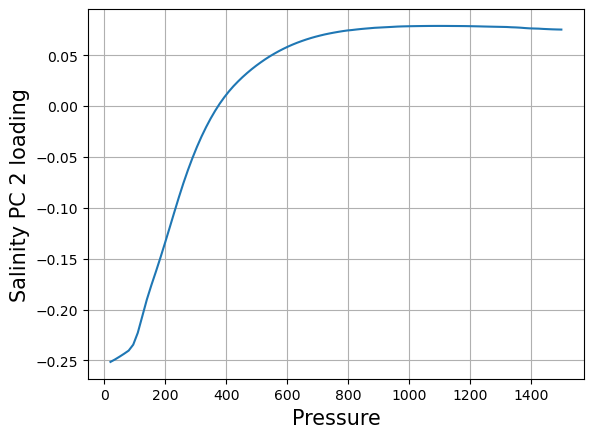

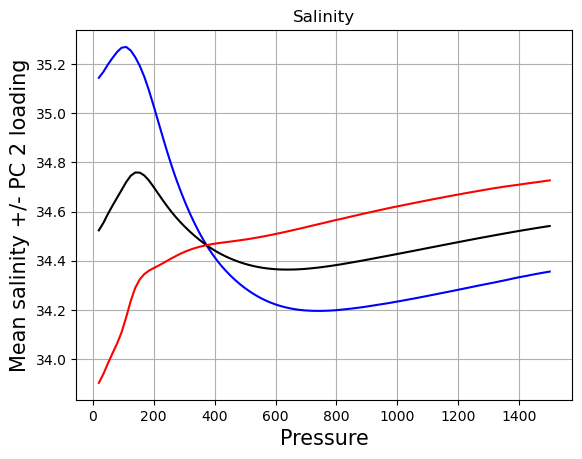

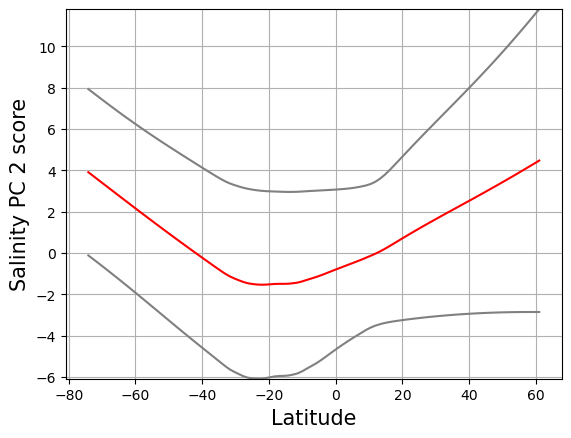

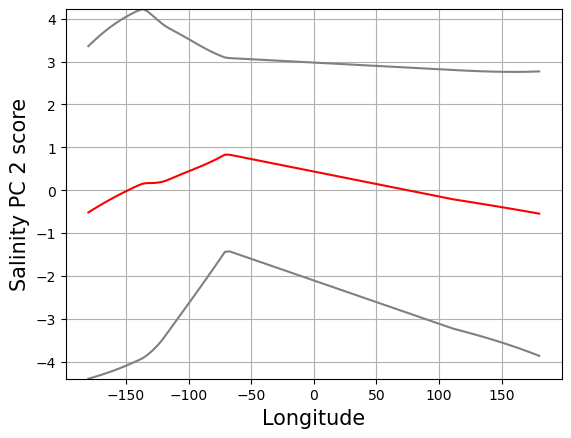

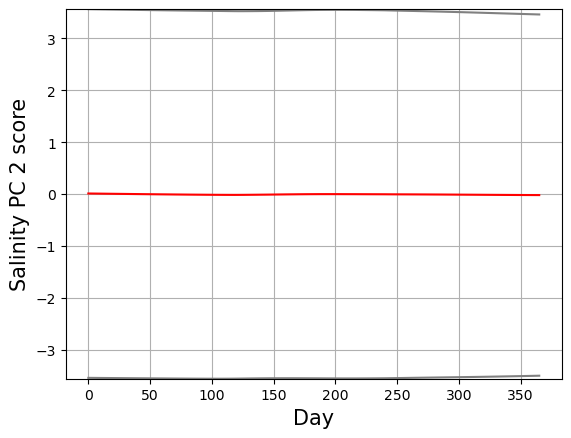

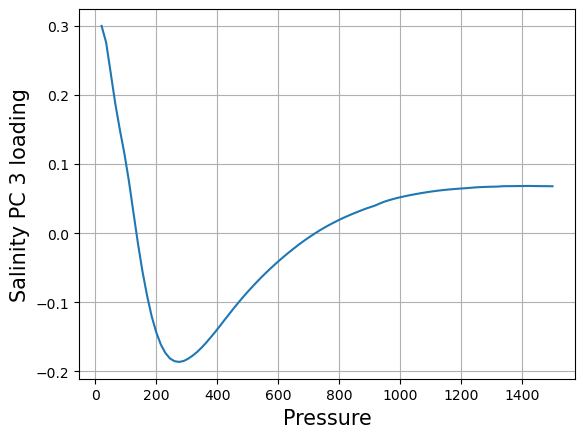

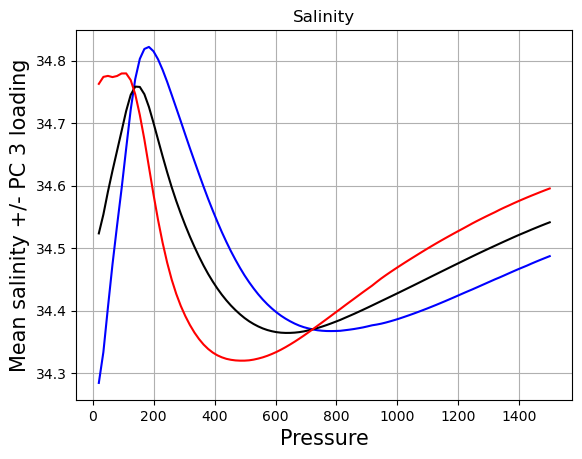

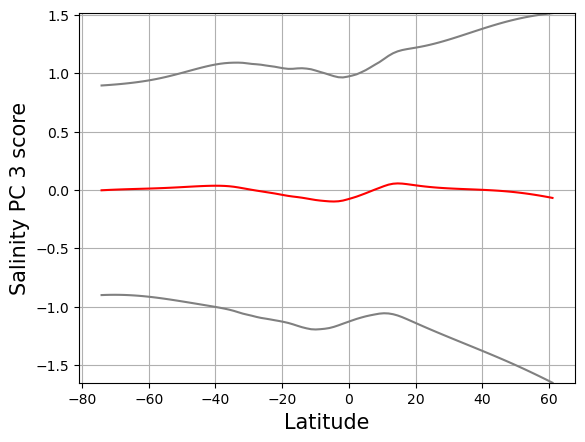

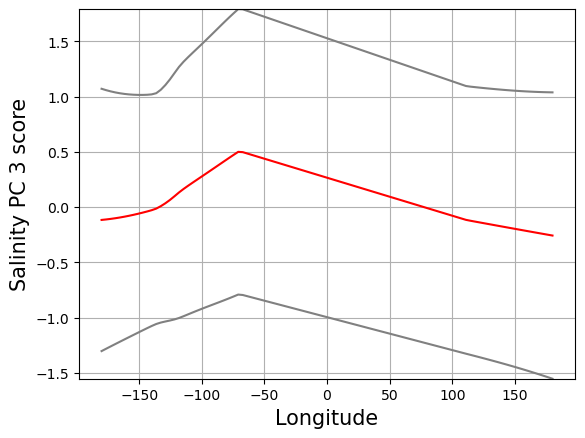

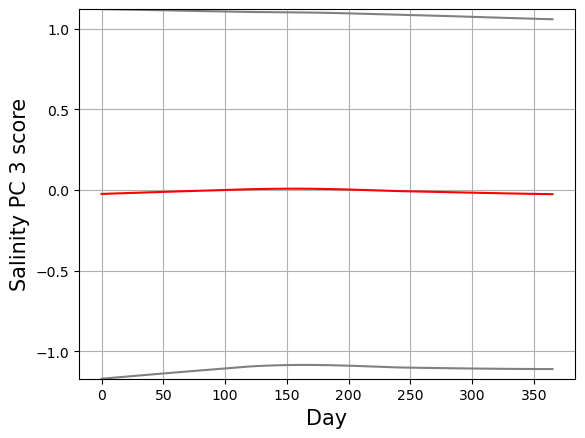

In [16]:
for j in range(3):
    pcplot(j, psalmean, psalv, psalscores, "salinity")

## Canonical Correlation Analysis

CCA looks specifically at how temperature and salinite are correlated.  It identifies linear projections $a^\prime Y$ and $b^\prime Z$ of the temperature data ($Y$) and salinity data ($Z$) that are maximally correlated.

In [17]:
def my_cca(X, Y):
    """
    CCA that agrees with R.
    """
    n = X.shape[0]
    X = X - X.mean(0)
    Y = Y - Y.mean(0)
    Sx = np.dot(X.T, X) / n
    Sy = np.dot(Y.T, Y) / n
    Sxy = np.dot(X.T, Y) / n
    Rx = np.linalg.cholesky(Sx)
    Ry = np.linalg.cholesky(Sy)
    M = np.linalg.solve(Rx, Sxy)
    M = np.linalg.solve(Ry, M.T).T
    u, s, vt = np.linalg.svd(M)
    v = vt.T
    u = np.linalg.solve(Rx.T, u)
    v = np.linalg.solve(Ry.T, v)
    return u, v, s

Standard CCA, due to the high dimensionality and consequent overfitting, the results make little sense.

Text(0, 0.5, 'Canonical correlations')

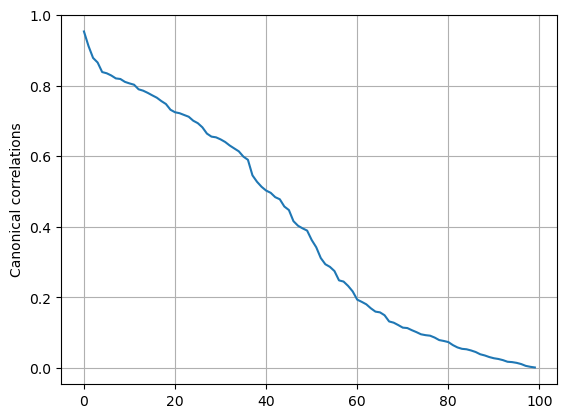

In [18]:
XX = temp.T.copy()
XX -= XX.mean(0)
YY = psal.T.copy()
YY -= YY.mean(0)
xc, yc, r = my_cca(XX, YY)
plt.clf()
plt.grid(True)
plt.plot(r)
plt.ylabel("Canonical correlations")

In [19]:
# Flip the CCA components as needed for interpretability
def flip(xc, yc):
    for j in range(xc.shape[1]):
        if (xc[:, j] > 0).mean() + (yc[:, j] > 0).mean() < 1:
            xc[:, j] *= -1
            yc[:, j] *= -1
    return xc, yc

In [20]:
# The columns of ux and uy are the PC's of the temperature and salinity data.
ux,sx,vtx = np.linalg.svd(XX, 0)
uy,sy,vty = np.linalg.svd(YY, 0)

Reduce the temperature and salinity data to PCs, then do CCA on the projected data and finally map the loadings back to the original coordinates (this is very similar to PCR but applied to CCA not to linear regression).

Canonical correlations:  [0.22403375]


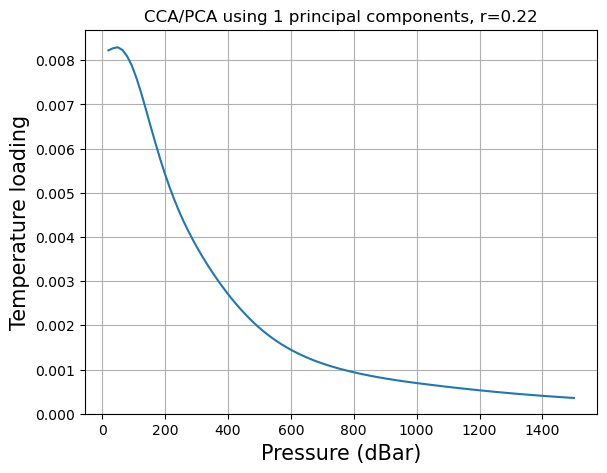

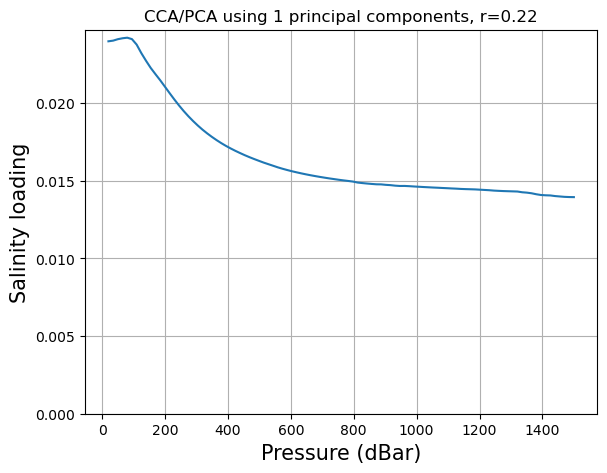

0.22403374523690636
Canonical correlations:  [0.81010637 0.01557733]


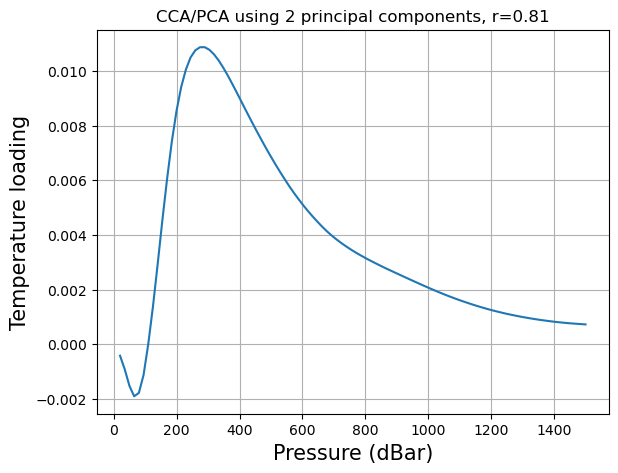

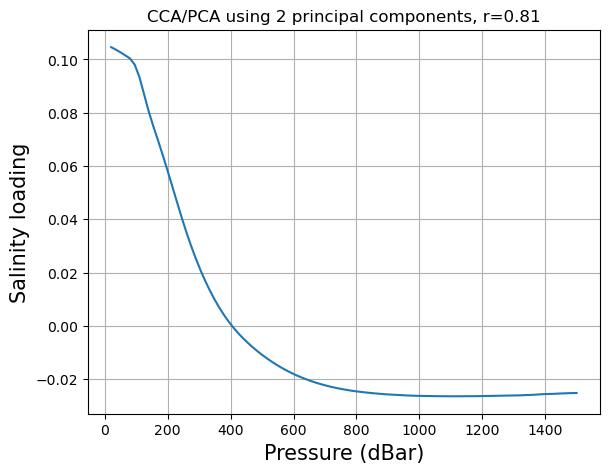

0.8101063683899828
Canonical correlations:  [0.92366984 0.79542656 0.57759066 0.14445159 0.00271726]


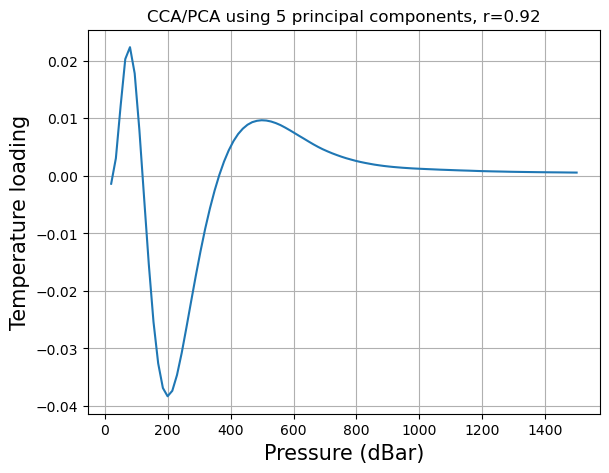

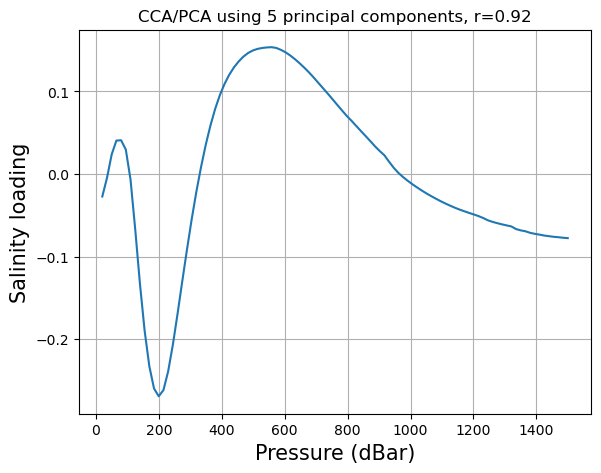

0.9236698431341686
Canonical correlations:  [0.94637464 0.89262956 0.7880764  0.75394293 0.57922476 0.47932617
 0.42496194 0.17196397 0.05336857 0.03484037]


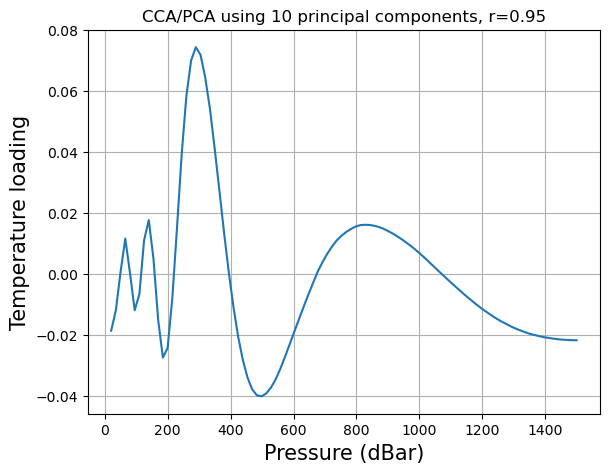

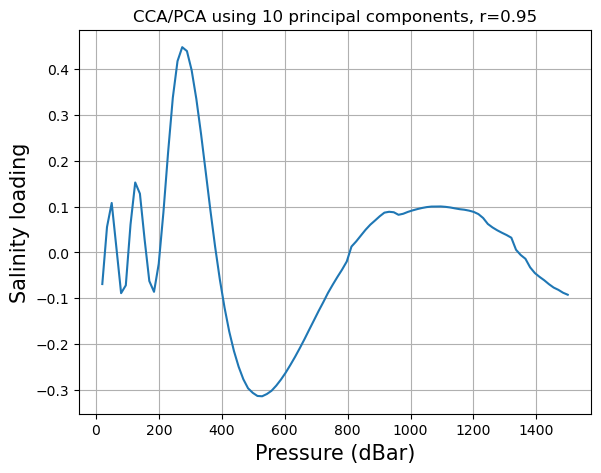

0.9463746377621354
Canonical correlations:  [0.94786945 0.90786259 0.86289168 0.81621817 0.79663423 0.73031302
 0.65706647 0.53035871 0.49872466 0.46685826 0.35484427 0.31923507
 0.28412884 0.24228606 0.1842928  0.16185253 0.11898494 0.1039864
 0.01140823 0.001867  ]


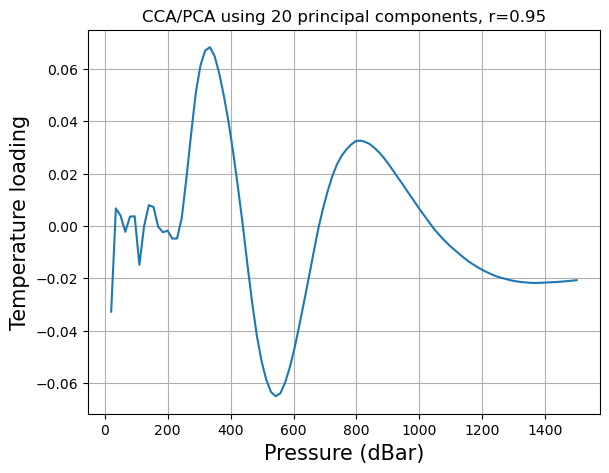

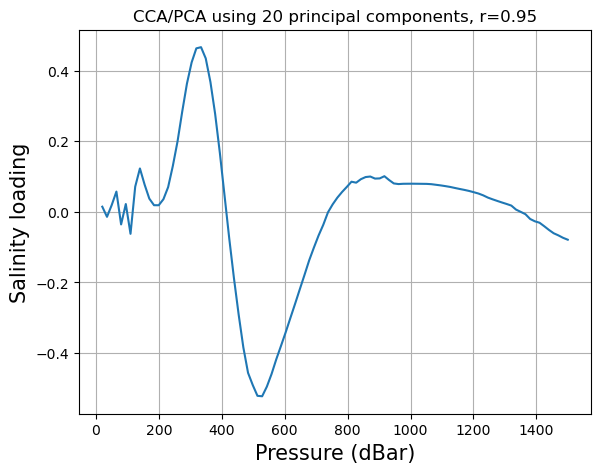

0.947869451744585
Canonical correlations:  [9.50397179e-01 9.10132083e-01 8.71541826e-01 8.37495437e-01
 8.35836353e-01 8.27467289e-01 8.26292473e-01 8.17302499e-01
 8.16299935e-01 8.07888164e-01 8.03230744e-01 7.99810599e-01
 7.86074613e-01 7.82251434e-01 7.55565181e-01 7.44713481e-01
 7.25394733e-01 7.17127167e-01 7.11433835e-01 7.07713413e-01
 6.83633829e-01 6.44727840e-01 6.27158411e-01 5.89758613e-01
 5.83617157e-01 5.37122501e-01 5.17448325e-01 4.85762286e-01
 4.50422714e-01 4.29290556e-01 4.09364708e-01 4.02123841e-01
 3.41576967e-01 3.34993637e-01 2.96623498e-01 2.43220286e-01
 2.13967459e-01 1.79408018e-01 1.55222333e-01 1.26270024e-01
 1.10446306e-01 8.26742023e-02 6.38524339e-02 4.93831892e-02
 2.78916950e-02 1.98768525e-02 1.31540714e-02 1.10050861e-02
 4.65733782e-03 7.16457601e-04]


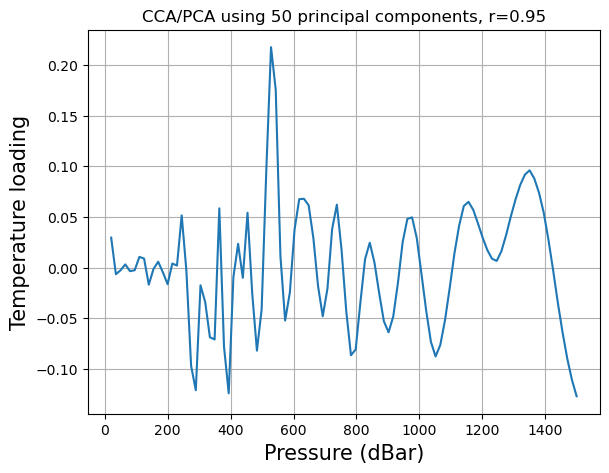

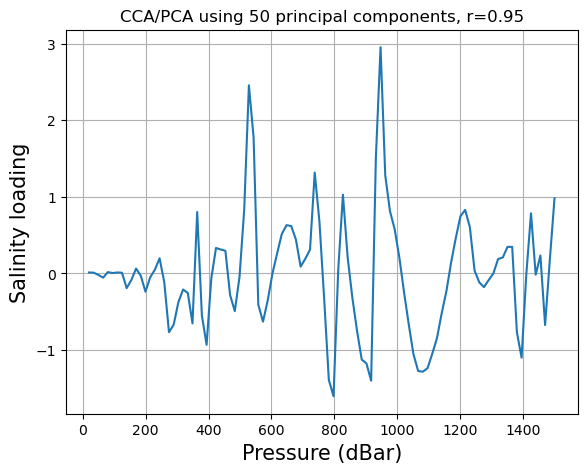

0.9503971794282405


In [21]:
for q in [1, 2, 5, 10, 20, 50]:

    # Do CCA after projecting the profiles to the top q PC's.
    xc, yc, r = my_cca(ux[:, 0:q], uy[:, 0:q])
    
    # The canonical correlations
    print("Canonical correlations: ", r)

    # Map the loadings back to the original coordinates
    xl1 = np.dot(vtx.T[:, 0:q], np.linalg.solve(np.diag(sx[0:q]), xc))
    yl1 = np.dot(vty.T[:, 0:q], np.linalg.solve(np.diag(sy[0:q]), yc))
    xl1, yl1 = flip(xl1, yl1)

    # Plot the temperature loadings
    plt.clf()
    plt.axes([0.15, 0.1, 0.8, 0.8])
    plt.grid(True)
    plt.title("CCA/PCA using %d principal components, r=%.2f" % (q, r[0]))
    plt.plot(pressure, xl1[:, 0])
    if xl1[:, 0].min() > 0:
        plt.ylim(ymin=0)
    plt.xlabel("Pressure (dBar)", size=15)
    plt.ylabel("Temperature loading", size=15)
    plt.show()

    # Plot the salinity loadings
    plt.clf()
    plt.axes([0.15, 0.1, 0.8, 0.8])
    plt.title("CCA/PCA using %d principal components, r=%.2f" % (q, r[0]))
    plt.grid(True)
    plt.plot(pressure, yl1[:, 0])
    if yl1[:, 0].min() >= 0:
        plt.ylim(ymin=0)
    plt.xlabel("Pressure (dBar)", size=15)
    plt.ylabel("Salinity loading", size=15)
    plt.show()
    print(np.corrcoef(np.dot(XX, xl1[:, 0]), np.dot(YY, yl1[:, 0]))[0,1])

Similar to what we did with PCA, we can plot the locations where profiles score at the high or low end of the range of scores.  These plots reveal that in a region of the south Pacific from Australia to Fiji, the temperatures are uniformly warmer and salinity is higher, whereas in the far northern/sourthern parts of the Pacific ocean, the temperatures are lower and salinity is lower.

<Figure size 640x480 with 0 Axes>

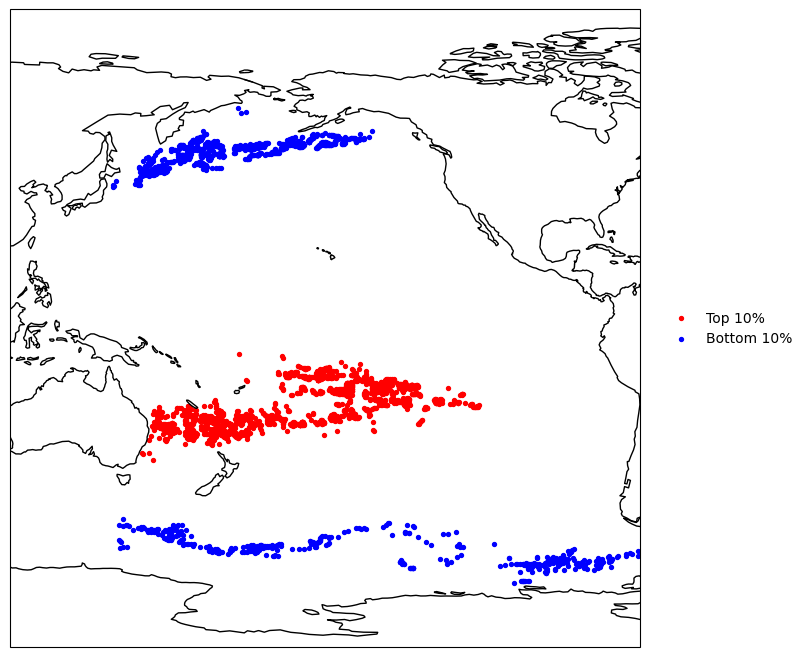

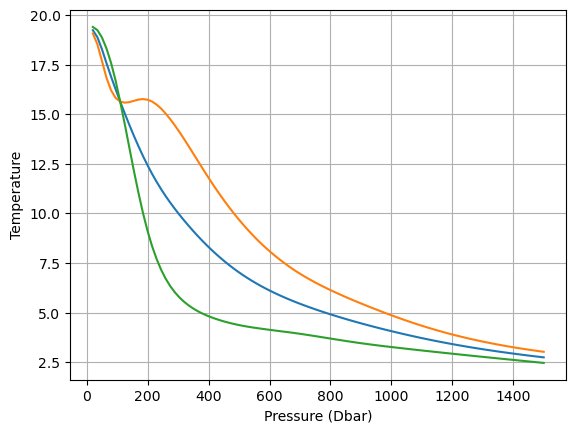

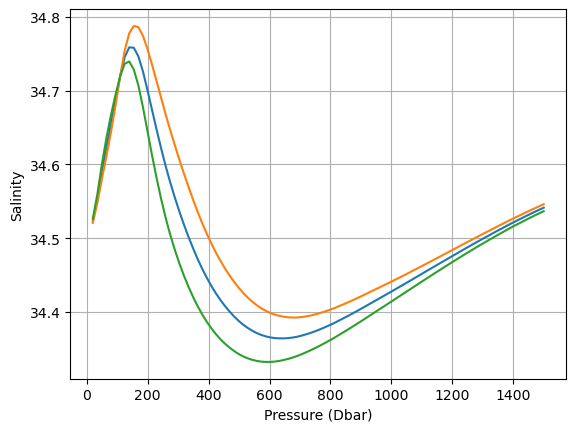

In [22]:
def plot_cc_map(q=2):
    
    # Do CCA after projecting the profiles to the top q PC's.
    xc, yc, r = my_cca(ux[:, 0:q], uy[:, 0:q])

    plt.clf()
    plt.figure(figsize=(9, 7.25))
    ax = plt.axes([0.05, 0.05, 0.84, 0.88], projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    ax.set_extent([115, 290, -70, 60])

    xx = np.dot(ux[:, 0:q], xc)
    yy = np.dot(uy[:, 0:q], yc)
    j1 = xx[:, 0] >= np.quantile(xx[:, 0], 0.9)
    j2 = yy[:, 0] >= np.quantile(yy[:, 0], 0.9)
    jj = np.flatnonzero(j1 & j2)
 
    k1 = xx[:, 0] <= np.quantile(xx[:, 0], 0.1)
    k2 = yy[:, 0] <= np.quantile(yy[:, 0], 0.1)
    kk = np.flatnonzero(k1 & k2)
    
    plt.scatter(Y[jj, 1], Y[jj, 0], s=8, label="Top 10%", color="red", transform=ccrs.Geodetic(), rasterized=True)
    plt.scatter(Y[kk, 1], Y[kk, 0], s=8, label="Bottom 10%", color="blue", transform=ccrs.Geodetic(), rasterized=True)

    ha,lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)
    plt.show()
    
    # Plot mean temperature profile +/- 1SD CC factor loading
    plt.clf()
    plt.grid(True)
    plt.plot(pressure, tempmean, "-")
    xl1 = np.dot(vtx.T[:, 0:q], np.linalg.solve(np.diag(sx[0:q]), xc))
    yl1 = np.dot(vty.T[:, 0:q], np.linalg.solve(np.diag(sy[0:q]), yc))
    xl1, yl1 = flip(xl1, yl1)
    xs = np.dot(XX, xl1) / (xl1**2).sum(0) # Regression estimate of the scores
    f = np.std(xs[:, 0])
    plt.plot(pressure, tempmean + f*xl1[:, 0])    
    plt.plot(pressure, tempmean - f*xl1[:, 0])    
    plt.xlabel("Pressure (Dbar)")
    plt.ylabel("Temperature")
    plt.show()

    # Plot mean salinity profile +/- 1SD CC factor loading
    plt.clf()
    plt.grid(True)
    plt.plot(pressure, psalmean, "-")
    ys = np.dot(YY, yl1) / (yl1**2).sum(0) # Regression estimate of the scores
    f = np.std(ys[:, 0])
    plt.plot(pressure, psalmean + f*xl1[:, 0])    
    plt.plot(pressure, psalmean - f*xl1[:, 0])    
    plt.xlabel("Pressure (Dbar)")
    plt.ylabel("Salinity")
    plt.show()

plot_cc_map()

## Dimension reduction regression

Below we use Sliced Inverse Regression to predict latitude from the first q principal components of the temperature data.  This shows us how temperature profiles differ with latitude.

In [23]:
q = 5
m = SIR(lat, ux[:, 0:q])
r = m.fit()
cf = np.dot(vtx.T[:, 0:q], np.linalg.solve(np.diag(sx[0:q]), r.params))

Plot the SIR loadings.

Text(0, 0.5, 'SIR loading')

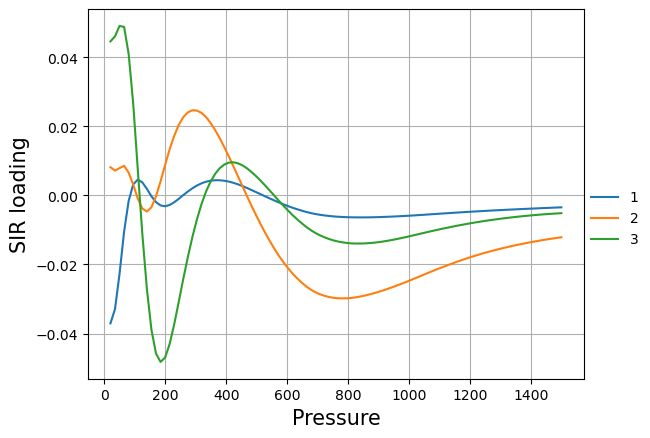

In [24]:
plt.clf()
plt.grid(True)
for j in range(3):
    plt.plot(pressure, cf[:, j], "-", label="%d" % (j + 1))
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="center right")
leg.draw_frame(False)
plt.xlabel("Pressure", size=15)
plt.ylabel("SIR loading", size=15)

Plot the SIR scores against latitude, and smooth to estimate their conditional means.

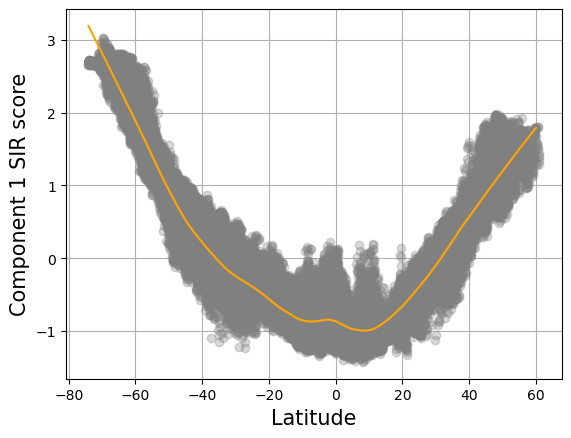

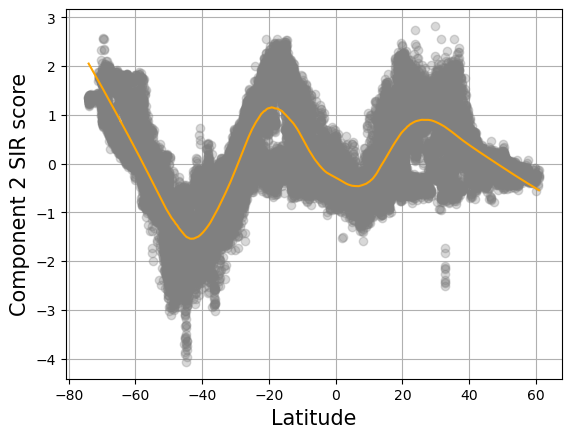

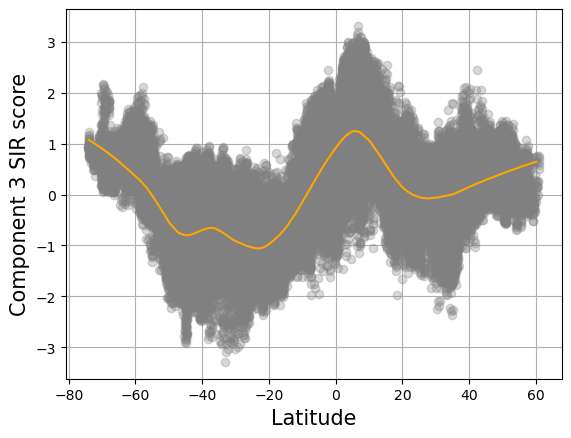

In [25]:
scores = np.dot(XX, cf)
for j in range(3):
    plt.clf()
    plt.grid(True)
    plt.plot(lat, scores[:, j], "o", color="grey", alpha=0.3, rasterized=True)

    # Use lowess to estimate the conditional mean of the scores given latitude.
    # Lowess is slow and doesn't need all the data to give an accurate estimate.
    ii = np.random.choice(np.arange(scores.shape[0]), 2000, replace=False)
    m = lowess(scores[ii, j], lat[ii], frac=0.2)
    plt.plot(m[:, 0], m[:, 1], "-", color="orange")

    plt.xlabel("Latitude", size=15)
    plt.ylabel("Component %d SIR score" % (j + 1), size=15)
    plt.show()